# Применение глубинного обучения для оптимизации портфеля ценных бумаг

## Введение

В этом исследовании мы рассмотрим применение машинного обучения и глубинного обучения для прогнозирования доходности акций и формирования оптимального инвестиционного портфеля. Результаты сравним с базовой стратегией «__Купи и держи__» без ребалансировки портфеля и оценим эффективность предложенных подходов с помощью ключевых финансовых метрик:

- ##### Коэффициент Шарпа (Sharpe ratio)
    $$
    \text{Sharpe ratio} = \frac{R_p - R_f}{\sigma_p}
    $$

    где:
    - $R_p$ – средняя доходность портфеля
    - $R_f$ – безрисковая ставка доходности
    - $\sigma_p$– волатильность доходности портфеля

- ##### Коэффициент Сортино (Sortino ratio)
    $$
    \text{Sortino ratio} = \frac{R_p - R_f}{\sigma_{downside}}
    $$

    где:
    - $R_p$ – средняя доходность портфеля
    - $R_f$ – безрисковая ставка доходности
    - $\sigma_{downside}$ – стандартное отклонение __отрицательных__ доходностей

- ##### Максимальная просадка (Max drawdown)
    $$
    \text{Max DD} = \max_{t \in [0,T]} \left(\frac{V_{peak} - V_{t}}{V_{peak}}\right)
    $$

    где:
    - $V_{peak}$ – максимальное историческое значение стоимости портфеля
    - $V_{t}$ – стоимость портфеля на момент времени $t$

Импортируем необходимые модули и библиотеки.

In [1]:
import pandas as pd
import numpy as np
import random
from src.ploting.utils import *

import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from src.portfolio.download import MOEXCandlesFetcher
from src.portfolio.backtest import Backtester
from src.portfolio.black_litterman_opt import BlackLittermanOptimizer
from src.signals.anomaly_detector import AnomalyDetector
from src.signals.signal_classifier import SignalClassifier
from src.dnn.prepare_dataloaders import FinTSDataloaders
from src.dnn.lstm_forecast import LSTMForecaster
from src.dnn.gru_forecast import GRUForecaster
from src.dnn.attention_lstm import AttentionLSTMForecaster
from src.dnn.attention_gru import AttentionGRUForecaster
from src.dnn.trainer import Trainer

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(123)

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

%matplotlib inline

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [3]:
BACKTEST_DATE = "2024-10-17"
INIT_CASH = 100_000

## Загрузка исторических данных с Московской биржи

Для анализа были выбраны 8 крупнейших российских компаний из разных отраслей (таблица ниже). Данные загружаются за период с 1 января 2015 года по вчерашний день с помощью класса `MOEXCandlesFetcher`. Полученные данные сохраняются в .csv файл для дальнейшего использования.

| Тикер | Компания            | Отрасль                 |
|-------|---------------------|-------------------------|
| YNDX, YDEX | Яндекс              | Информационные технологии |
| MGNT | Магнит | Потребительский сектор (розничная торговля) |
| LKOH, GAZP, ROSN, NVTK | Лукойл, Газпром, Роснефть, Новатэк     | Энергетика и добыча сырья |
| SBER  | Сбер                | Финансовый сектор       |
| CHMF  | Северсталь          | Металлургия и добыча сырья |

In [4]:
TICKERS = ["YNDX", "YDEX", "LKOH", "MGNT", "ROSN", "GAZP", "SBER", "CHMF", "NVTK"]

data_path = "./data/moex_may_report.csv"
fetcher = MOEXCandlesFetcher()
df = fetcher.run(data_path=data_path, tickers=TICKERS, from_date="2015-01-01")

Загружены ранее скачанные данные ./data/moex_may_report.csv.


Также загрузим индексы:
- `IMOEX - Индекс Мосбиржи`. Понадобится для реализации модели Блэка-Литтермана для оптимизации весов;
- `MCFTR - Индекс Мосбиржи полной доходности "брутто"`. Будем использовать в качестве первого бенчмарка;
- `RGBITR - Индекс Мосбиржи государственных облигаций`. Будем использовать в качестве второго бенчмарка.

In [5]:
imoex = pd.read_csv("./data/IMOEX_may_report.csv", sep=";", parse_dates=["date"])
mcftr = pd.read_csv("./data/MCFTR_may_report.csv", sep=";", parse_dates=["date"])
rgbitr = pd.read_csv("./data/RGBITR_may_report.csv", sep=";", parse_dates=["date"])

Посмотрим на случайную выборку и заполним пропуски:

In [6]:
df.sample(5)

,ticker,date,open,low,high,close,volume
2874,GAZP,2016-01-19,125.52,125.30,128.40,125.98,36452020
10890,NVTK,2016-09-21,642.30,638.10,648.00,643.30,684380
2753,GAZP,2015-07-27,136.10,133.13,136.37,134.51,31642430
4733,GAZP,2023-05-30,162.15,161.50,165.40,161.90,40687470
9718,MGNT,2022-06-10,4299.00,4185.00,4331.00,4241.00,103762


In [7]:
df.isna().sum()

ticker      0
date        0
open      174
low       174
high      174
close     174
volume      0
dtype: int64

In [8]:
data = df.ffill().bfill()
data.isna().sum()

ticker    0
date      0
open      0
low       0
high      0
close     0
volume    0
dtype: int64

Визуализируем __историю цен закрытия__ по всем тикерам.

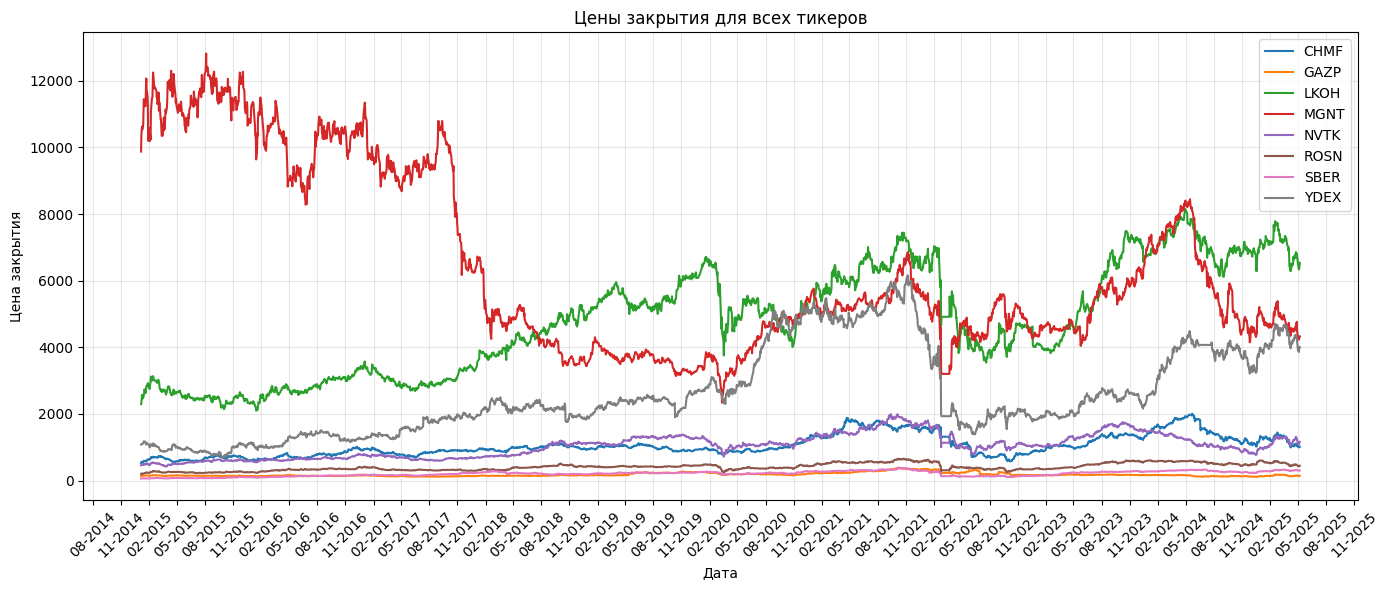

In [9]:
plot_close_prices(df=data)

## Реализация бейзлайн стратегии "Купи и держи"

Делаем бэктест стратегии "Купи и держи" на последних 10% данных каждого тикера и смотрим на перфоманс равновесного портфеля.

In [10]:
backtester = Backtester(
    df=data,
    init_cash=INIT_CASH,
    fees=0.01,
    test_start_date=BACKTEST_DATE
)

In [11]:
mcftr_bt = Backtester(df=mcftr, init_cash=100_000, fees=0.01, test_start_date=BACKTEST_DATE)
mcftr_pf = mcftr_bt.run_buy_and_hold()

rgbitr_bt = Backtester(df=rgbitr, init_cash=100_000, fees=0.01, test_start_date=BACKTEST_DATE)
rgbitr_pf = rgbitr_bt.run_buy_and_hold()

Можно посмотреть на статистические характеристики данных: среднее, стандартное отклонение и корреляция. В методе `check_stat_measures` необходимо выбрать mode `close` (цены закрытия) или `returns` (доходность) и выбрать ключ `mean`, `std`, `corr`.

In [12]:
backtester.check_stat_measures(mode="returns")["mean"]

ticker
CHMF   -0.000728
GAZP    0.000712
LKOH   -0.000275
MGNT   -0.000595
NVTK    0.001757
ROSN   -0.000409
SBER    0.001348
YDEX    0.000279
dtype: float64

In [13]:
backtester.check_stat_measures(mode="returns")["std"]

ticker
CHMF    0.028461
GAZP    0.027185
LKOH    0.016758
MGNT    0.022802
NVTK    0.028949
ROSN    0.022232
SBER    0.020090
YDEX    0.023053
dtype: float64

In [14]:
backtester.check_stat_measures(mode="returns")["corr"]

ticker,CHMF,GAZP,LKOH,MGNT,NVTK,ROSN,SBER,YDEX
ticker,,,,,,,,
CHMF,1.000000,0.750711,0.687176,0.628314,0.735787,0.714332,0.776552,0.772890
GAZP,0.750711,1.000000,0.669161,0.574027,0.748944,0.711727,0.761590,0.765435
LKOH,0.687176,0.669161,1.000000,0.558635,0.713746,0.700118,0.744747,0.689911
MGNT,0.628314,0.574027,0.558635,1.000000,0.586770,0.631527,0.732140,0.620606
NVTK,0.735787,0.748944,0.713746,0.586770,1.000000,0.729417,0.809049,0.822295
ROSN,0.714332,0.711727,0.700118,0.631527,0.729417,1.000000,0.783232,0.755936
SBER,0.776552,0.761590,0.744747,0.732140,0.809049,0.783232,1.000000,0.860051
YDEX,0.772890,0.765435,0.689911,0.620606,0.822295,0.755936,0.860051,1.000000


In [15]:
bh_portfolio = backtester.run_buy_and_hold()

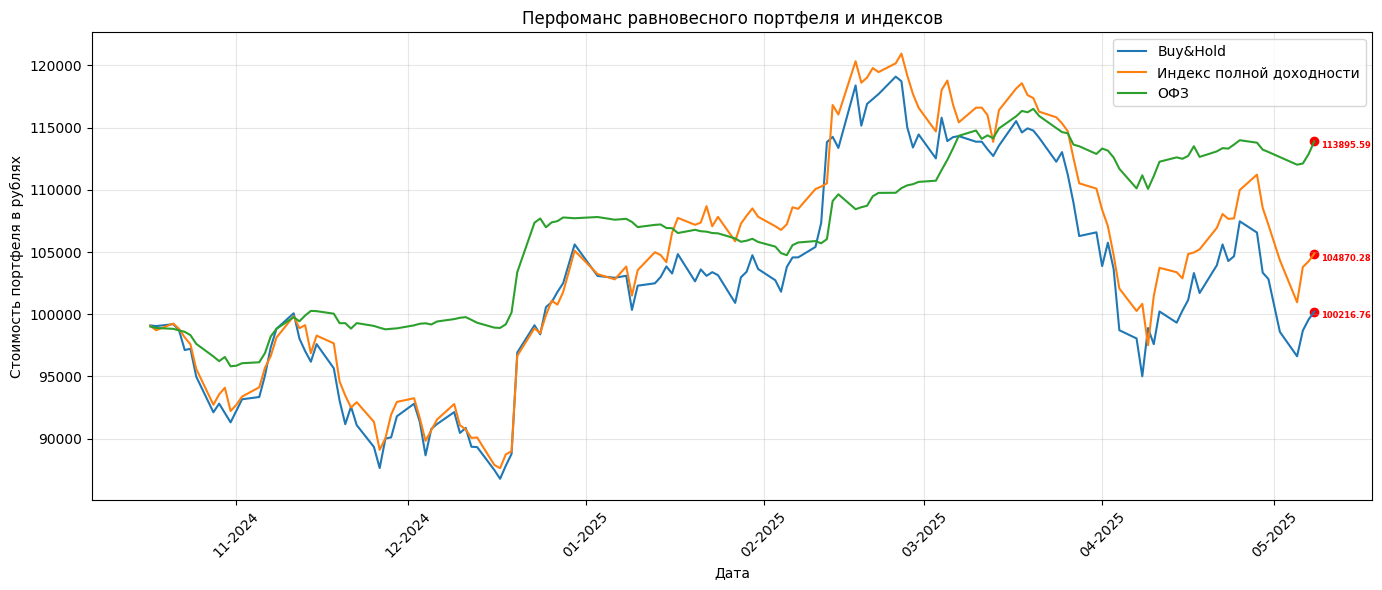

In [16]:
plot_equity(equity_series={"Buy&Hold": bh_portfolio.value(),
                           "Индекс полной доходности": mcftr_pf.value(),
                           "ОФЗ": rgbitr_pf.value()}, 
            title="Перфоманс равновесного портфеля и индексов", 
            ylabel="Стоимость портфеля в рублях", 
            last_point=True)

In [17]:
# Метрики индекса полной доходности
mcftr_bt.portfolio_performance(portfolio=mcftr_pf)

Sharpe ratio: 0.44
Sortino ratio: 0.71
Max drawdown: -19.38%
Total return: 4.87%


In [18]:
# Метрики ОФЗ
rgbitr_bt.portfolio_performance(portfolio=rgbitr_pf)

Sharpe ratio: 2.20
Sortino ratio: 4.58
Max drawdown: -5.52%
Total return: 13.90%


In [19]:
# Метрики равновесного портфеля
backtester.portfolio_performance(portfolio=bh_portfolio)

Sharpe ratio: 0.16
Sortino ratio: 0.25
Max drawdown: -20.22%
Total return: 0.22%


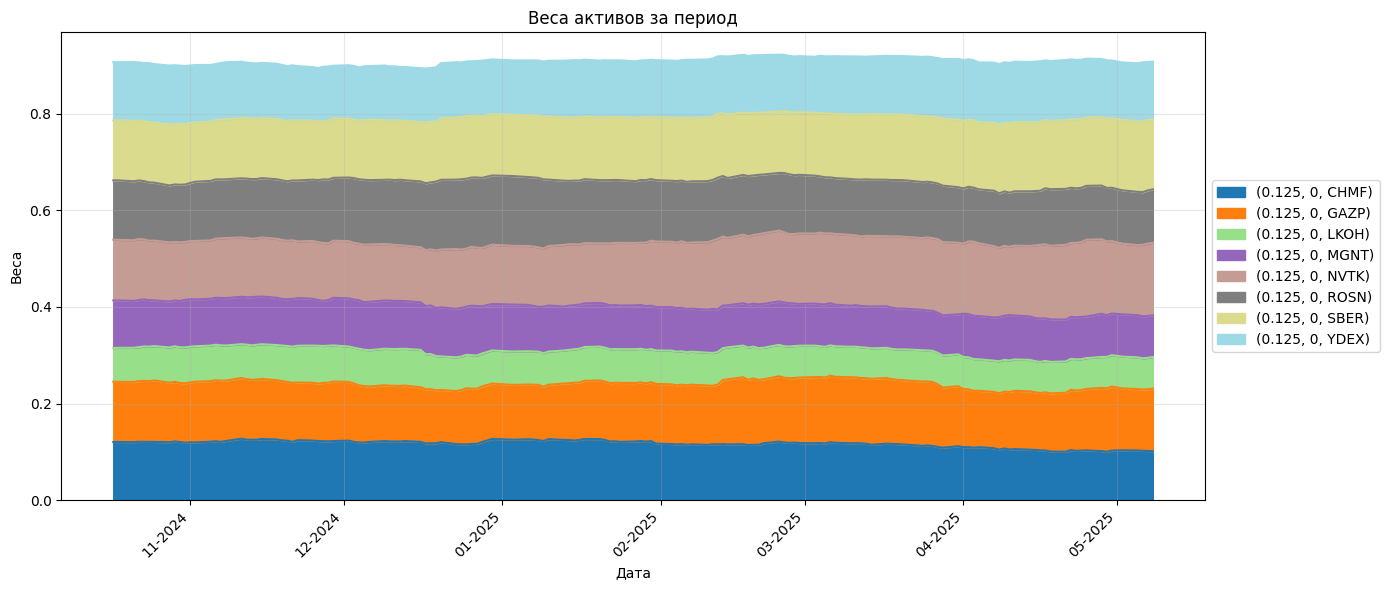

In [20]:
backtester.plot_weights(portfolio=bh_portfolio, mode="plt")

> __Вывод:__  
> Результаты стратегии «Купи и держи» без ребалансировки показывают небольшую доходность (0.22%), значения коэффициентов Шарпа (0.16) и Сортино (0.25), а также значительную максимальную просадку (20.22%) при практически нулевой доходности. Это указывает на низкую эффективность и высокий риск такого подхода на рассматриваемом периоде.

## Реализация кастомной сигнальной стратегии

Перейдем к реализации сигнальной стратегии. Сначала сделаем небольшой Feature engineering - с помощью класса `AnomalyDetector` создадим 2 признака: "anomaly_score" и "anomaly".

In [21]:
custom_params = {
    "n_estimators": 500,
    "contamination": 0.1,
    "n_jobs": -1,
    "random_state": 42,
    }

anomaly_detector = AnomalyDetector(df=data, model_params=custom_params)
extended_df, features = anomaly_detector.generate_features()

In [22]:
df_with_anomalies = anomaly_detector.detect_anomalies(train_period_end="2024-12-31")
df_with_anomalies.tail()

,ticker,date,open,low,high,close,volume,return,amplitude,anomaly_score,anomaly
20915,YDEX,2025-05-02,4108.0,3900.0,4113.0,3905.5,561535,-0.048831,0.054615,0.034430,1
20916,YDEX,2025-05-05,3940.0,3814.0,3976.0,3860.0,728771,-0.011650,0.042475,-0.102831,0
20917,YDEX,2025-05-06,3860.0,3817.0,4065.5,4013.0,787755,0.039637,0.065103,0.008001,1
20918,YDEX,2025-05-07,4014.0,3961.0,4092.0,3991.0,726922,-0.005482,0.033072,-0.136290,0
20919,YDEX,2025-05-08,3986.5,3986.5,4058.5,3993.5,234721,0.000626,0.018061,-0.143466,0


Посмотрим на аномалии и убедимся, что модель действительно работает. 

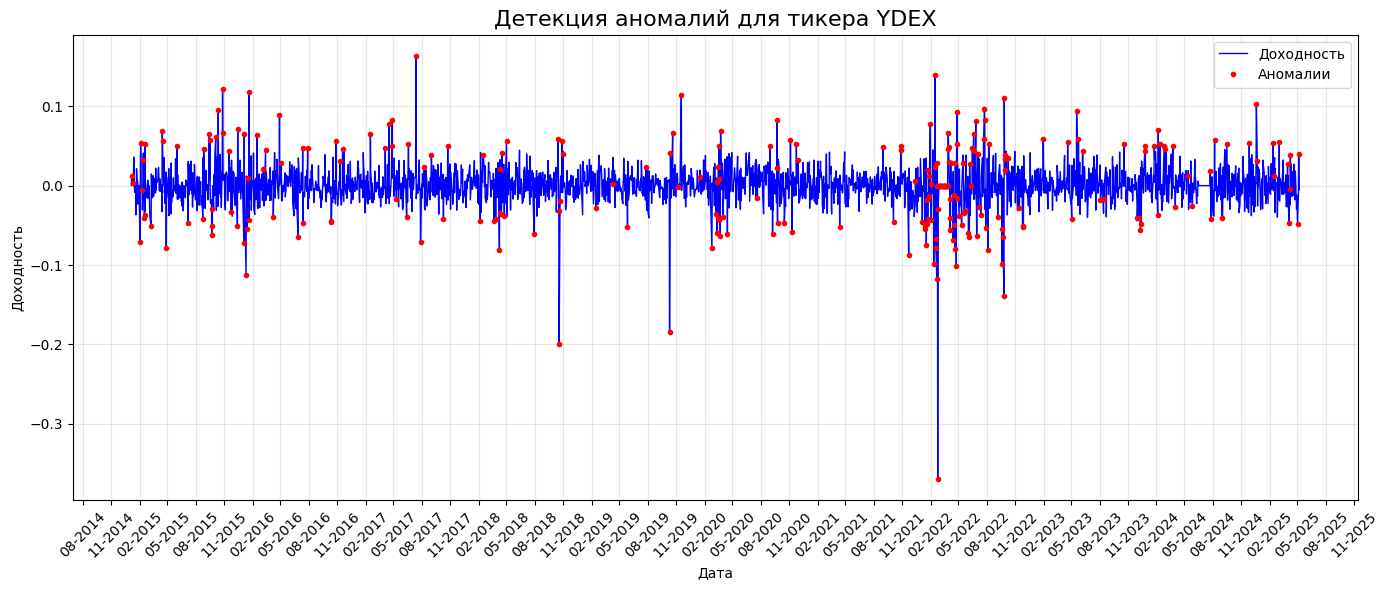

In [23]:
anomaly_detector.visualize_anomalies(ticker="YDEX", is_interactive=False)

Для того, чтобы классификатор адекватно работал, необходимо сгенерировать больше признаков, а также разметить целевую переменную (bullish, bearish, neutral сигналы).

In [24]:
gen_features = [
    "momentum_5", "momentum_10",
    "std_5", "std_10",
    "bollinger_bands_20", "bollinger_width_20",
    "atr_14", "atr_7",
    "volume_ratio_10", "volume_ratio_20", "volume_ratio_5",
    "amplitude_mean_10", "amplitude_mean_5",
    "rsi_14", "rsi_7",
    "ema_10", "ema_20", 
    "sma_10", "sma_20",
    "return_lag_10", "return_lag_20"
]

Существует несколько стратегий определения bullish/bearish сигналов:
- Стратегия на основе порогов доходности;
- Стратегия на основе пересечения скользящих средних;
- Стратегия на основе технических индикаторов;
- Стратегия на основе волатильности;
- и др.

В данной работе рассматривается __стратегия на основе волатильности__, так как она подходит для рынков с выраженной волатильностью, коим и является российский рынок в настоящее время.

__Идея__:
- Сначала вычисляется будущая доходность акций на горизонте $N$ дней (`future_return`) и текущая волатильность за последние 20 дней (`rolling_sigma`);
- На основе волатильности устанавливаются динамические пороги (+-5% от rolling_sigma) для формирования bullish, bearish, нейтрального сигналов;
- Затем формируется многоклассовый таргет: `-1 (bearish)`, `0 (нейтральный)`, `1 (bullish)`;
- Модель CatBoost обучается на bullish, bearish, нейтральных сигналах через последовательное временное разбиение данных.

In [25]:
signal_classifier = SignalClassifier(
    df=df_with_anomalies,
    features=gen_features,
    lookahead=10
)

Проверим сбалансированность классов:

In [26]:
signal_classifier.check_class_balance()

Баланс классов по тикерам:
CHMF:
target
 1    1056
-1     875
 0     684
Name: count, dtype: int64

GAZP:
target
 1    1008
-1     921
 0     686
Name: count, dtype: int64

LKOH:
target
 1    1044
-1     853
 0     718
Name: count, dtype: int64

MGNT:
target
-1    1008
 1     954
 0     653
Name: count, dtype: int64

NVTK:
target
 1    995
-1    868
 0    752
Name: count, dtype: int64

ROSN:
target
 1    1043
-1     881
 0     691
Name: count, dtype: int64

SBER:
target
 1    1134
-1     769
 0     712
Name: count, dtype: int64

YDEX:
target
 1    1067
-1     838
 0     710
Name: count, dtype: int64



In [27]:
signal_classifier.train(
    test_split_ratio=0.1,
    n_folds=5,
    gap=5
)

proba, signals = signal_classifier.evaluate(
    bull_threshold=0.4,
    bear_threshold=0.3
)

Дата разделения train/test: 2024-04-29
Оптимальное количество итераций: 81
0:	learn: 0.3326946	total: 20.8ms	remaining: 1.67s
80:	learn: 0.3716622	total: 2.09s	remaining: 0us


В целом уже видно, что значения F1-меры неудовлетворительные, модель плохо классифицирует сигналы. Посмотрим на топ-10 важных признаков:

In [28]:
feat_importance = signal_classifier.feature_importance()
feat_importance.head(10)

,Feature Id,Importances
0,bollinger_width_20,11.065922
1,std_10,8.047249
2,bollinger_bands_20,7.074734
3,atr_14,6.753661
4,rsi_14,5.709822
5,momentum_10,5.694558
6,volume_ratio_20,4.356111
7,sma_20,4.266696
8,rsi_7,4.098890
9,ema_10,3.688781


Проведем бэктест и убедимся, что данная модель не слишком надежная.

In [29]:
signal_portfolio = backtester.run_signal_backtest(
    signals_df=signals,
    size=12_500,
    size_type="value"
)

In [30]:
backtester.portfolio_performance(portfolio=signal_portfolio)

Sharpe ratio: -1.20
Sortino ratio: -1.69
Max drawdown: -18.91%
Total return: -13.20%


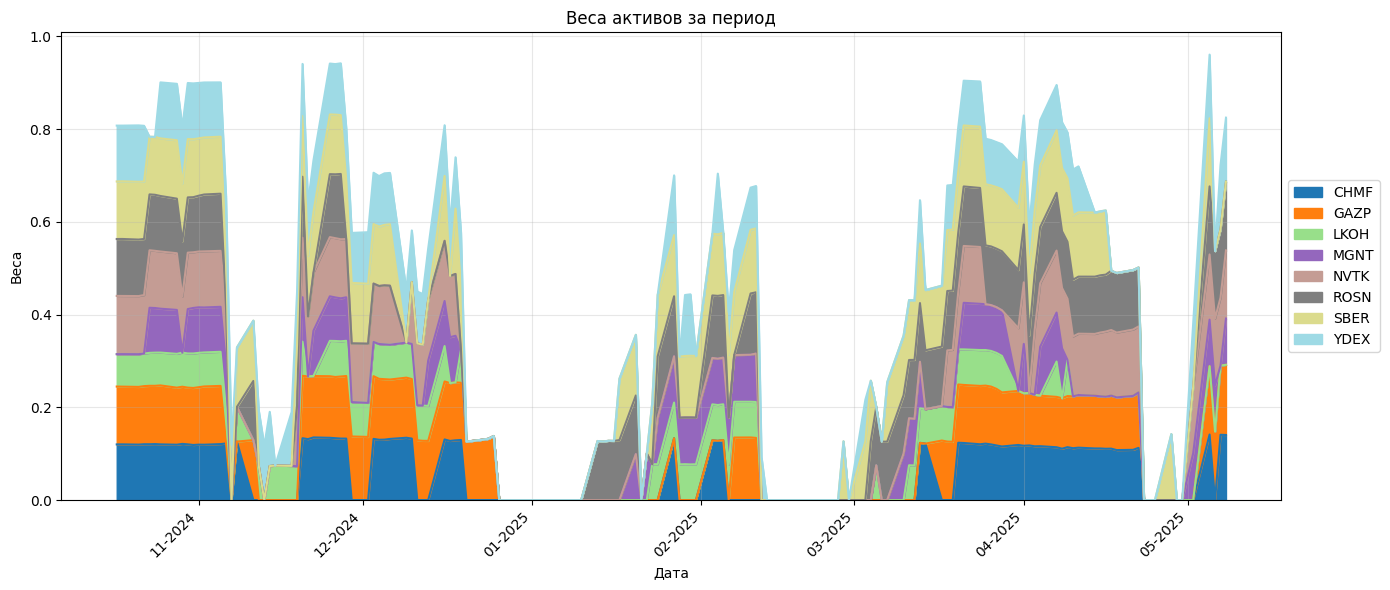

In [31]:
backtester.plot_weights(portfolio=signal_portfolio, mode="plt")

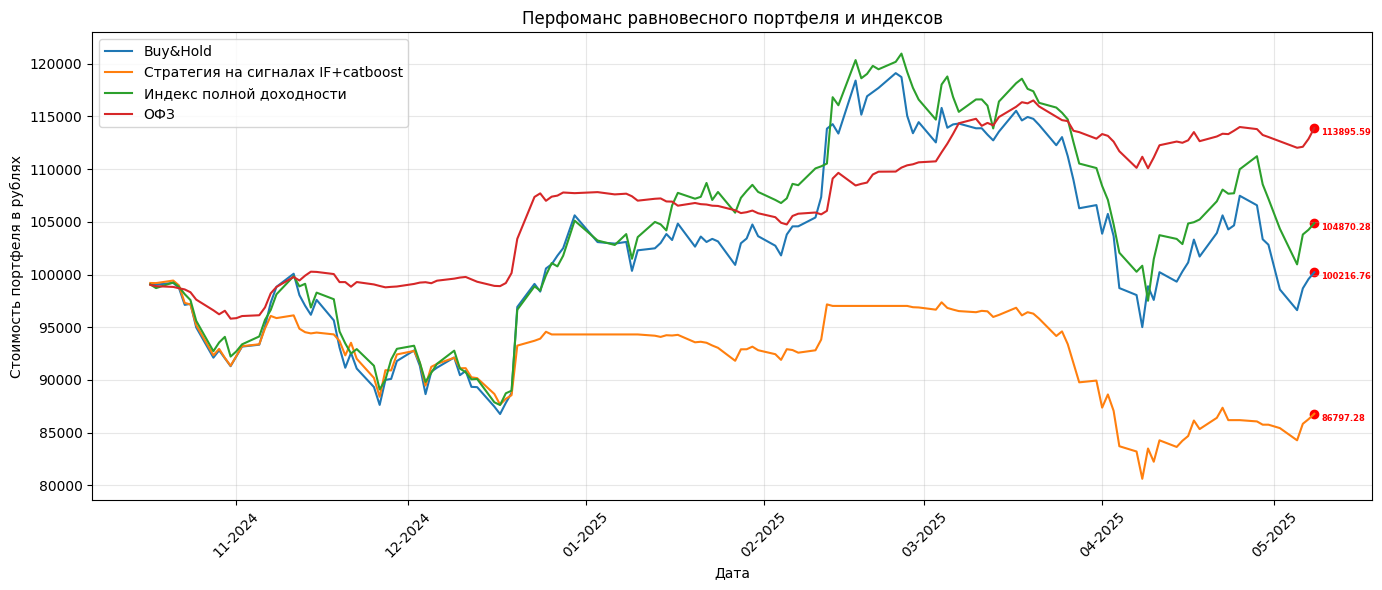

In [32]:
plot_equity(equity_series={"Buy&Hold": bh_portfolio.value(), 
                           "Стратегия на сигналах IF+catboost" : signal_portfolio.value(),
                           "Индекс полной доходности": mcftr_pf.value(),
                           "ОФЗ": rgbitr_pf.value()},
            title="Перфоманс равновесного портфеля и индексов", 
            ylabel="Стоимость портфеля в рублях", 
            last_point=True)

Для сравнения можно реализовать сигнальную стратегия на основе пересечения двух скользящих средних, возьмем `экспоненциальные скользящие средние`.

In [33]:
ema_portfolio = backtester.run_ema_crossover(
    short_window=10,
    long_window=20,
    size=12_500,
    size_type="value"
)

In [34]:
backtester.portfolio_performance(portfolio=ema_portfolio)

Sharpe ratio: 0.55
Sortino ratio: 0.85
Max drawdown: -11.43%
Total return: 4.30%


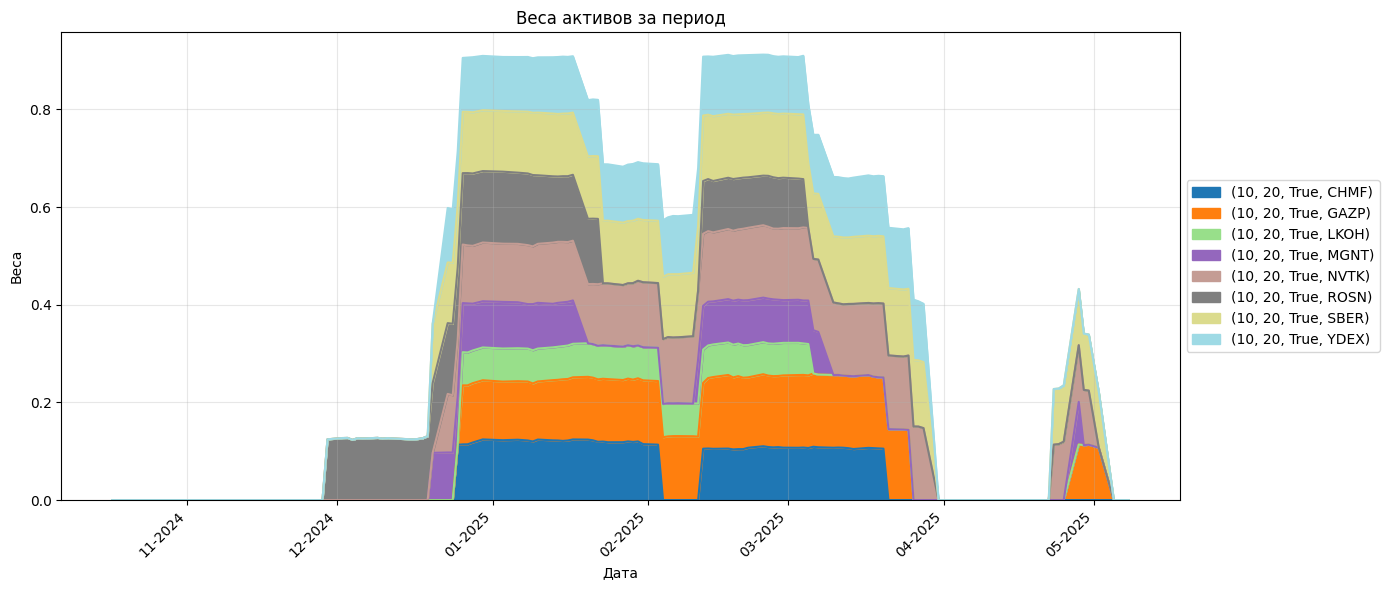

In [35]:
backtester.plot_weights(portfolio=ema_portfolio, mode="plt")

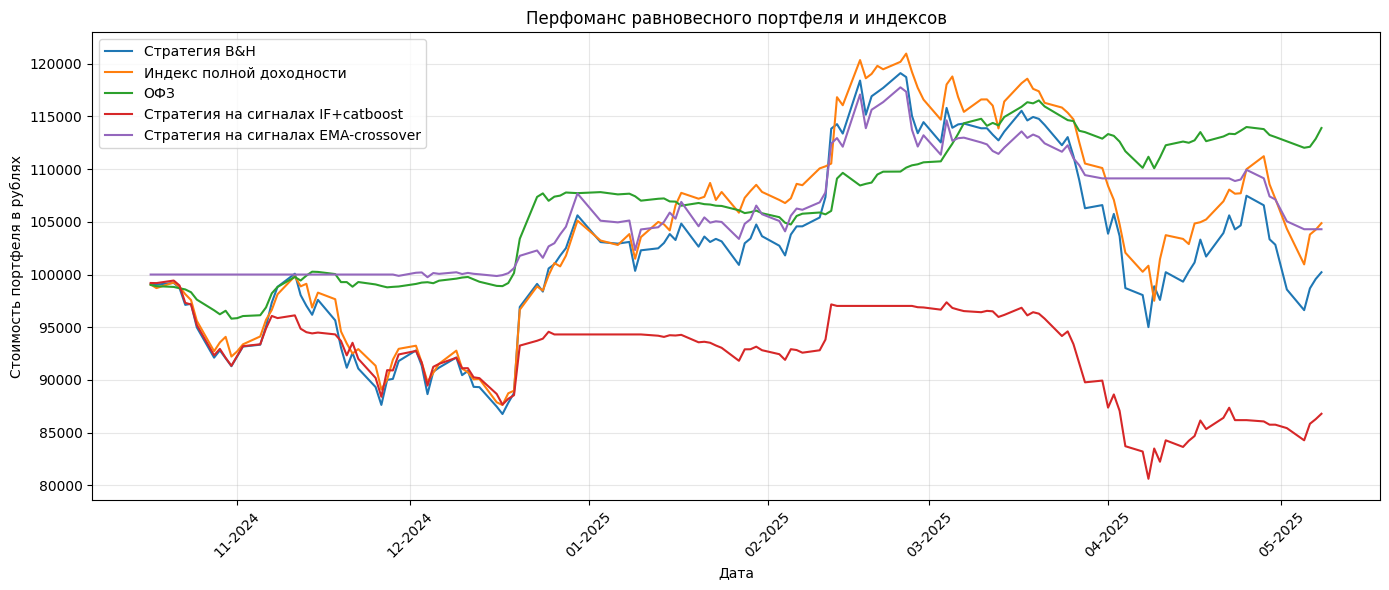

In [36]:
plot_equity(equity_series={"Стратегия B&H": bh_portfolio.value(),
                           "Индекс полной доходности": mcftr_pf.value(),
                           "ОФЗ": rgbitr_pf.value(), 
                           "Стратегия на сигналах IF+catboost" : signal_portfolio.value(),
                           "Стратегия на сигналах EMA-crossover" : ema_portfolio.value()},             
            title="Перфоманс равновесного портфеля и индексов", 
            ylabel="Стоимость портфеля в рублях", 
            last_point=False)

> __Вывод:__  
> Стратегия на сигналах продемонстрировала крайне низкие метрики по сравнению со стратегиями «купи и держи» и EMA-crossover. У стратегии на сигналах значительная потеря капитала (-13.2%), более глубокая просадка (18.91%) и худшие коэффициенты Шарпа и Сортино.

## CNN+LSTM модель прогнозирования доходностей

Особенность данной стратегии заключается в том, что помимо прочих признаков в LSTM необходимо передавать матрицу корреляций между тикерами, которая рассчитывается по определенному окну.
С помощью класса `FinTSDataloaders` можно подготовить dataloader'ы для LSTM, в которых создаются корреляционные матрицы и масштабируются прочие признаки.

In [37]:
loader_creator = FinTSDataloaders(
    df=data,
    window=60,
    forecast_horizon=14,
    batch_size=256
)
train_loader, val_loader, test_loader, feature_scaler, target_scaler = loader_creator.get_loaders()

In [38]:
X_batch, corr_batch, y_batch = next(iter(train_loader))
feature_dim = X_batch.shape[2]
num_tickers = y_batch.shape[1]

print(f"X batch:            {X_batch.shape}")
print(f"Corr matrix batch:  {corr_batch.shape}")
print(f"y batch:            {y_batch.shape}")
print(f"Feature dim:        {feature_dim}")
print(f"Num tickers:        {num_tickers}")

X batch:            torch.Size([256, 60, 112])
Corr matrix batch:  torch.Size([256, 60, 8, 8])
y batch:            torch.Size([256, 8])
Feature dim:        112
Num tickers:        8


Для обучения, валидации и тестирования моделей глубинного обучения реализован класс `Trainer`.

In [39]:
lstm_model = LSTMForecaster(
    feature_dim=feature_dim,
    num_tickers=num_tickers,
    lstm_hidden=128,
    lstm_layers=2,
    dropout=0.3,
    cnn_embed_dim=32
).to(DEVICE)

lstm_criterion = torch.nn.L1Loss()
lstm_optimizer = Adam(
    params=lstm_model.parameters(),
    lr=0.0005,
    weight_decay=0.001
)
lstm_scheduler = ReduceLROnPlateau(
    optimizer=lstm_optimizer,
    patience=10,
    factor=0.5
)

lstm_trainer = Trainer(
    model=lstm_model,
    criterion=lstm_criterion,
    optimizer=lstm_optimizer,
    scheduler=lstm_scheduler,
    device=DEVICE)

train_losses, val_losses = lstm_trainer.train(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    patience=20,
    model_name="lstm"
)

Эпоха [10/100] | Train loss: 0.449305 | Val loss: 0.443064
Эпоха [20/100] | Train loss: 0.351204 | Val loss: 0.361384
Эпоха [30/100] | Train loss: 0.306501 | Val loss: 0.325727
Эпоха [40/100] | Train loss: 0.277242 | Val loss: 0.299827
Эпоха [50/100] | Train loss: 0.269055 | Val loss: 0.298243
Эпоха [60/100] | Train loss: 0.261723 | Val loss: 0.293607
Эпоха [70/100] | Train loss: 0.255869 | Val loss: 0.292248
Эпоха [80/100] | Train loss: 0.257387 | Val loss: 0.288481
Эпоха [90/100] | Train loss: 0.252519 | Val loss: 0.289771
Ранняя остановка на эпохе 92


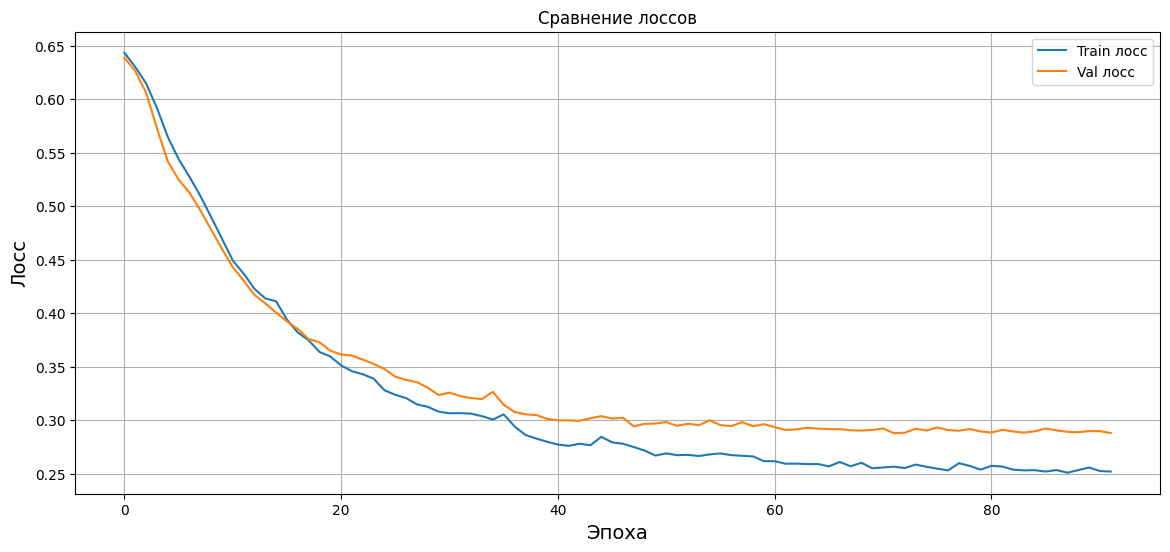

In [40]:
plot_losses(train_losses, val_losses)

In [41]:
lstm_loss = lstm_trainer.evaluate(dataloader=test_loader)

lstm_preds, lstm_targets, lstm_lb, lstm_ub = lstm_trainer.predict(
    dataloader=test_loader,
    target_scaler=target_scaler,
    train_loader=train_loader,
    ci_coef=1
)

Test loss: 0.413548


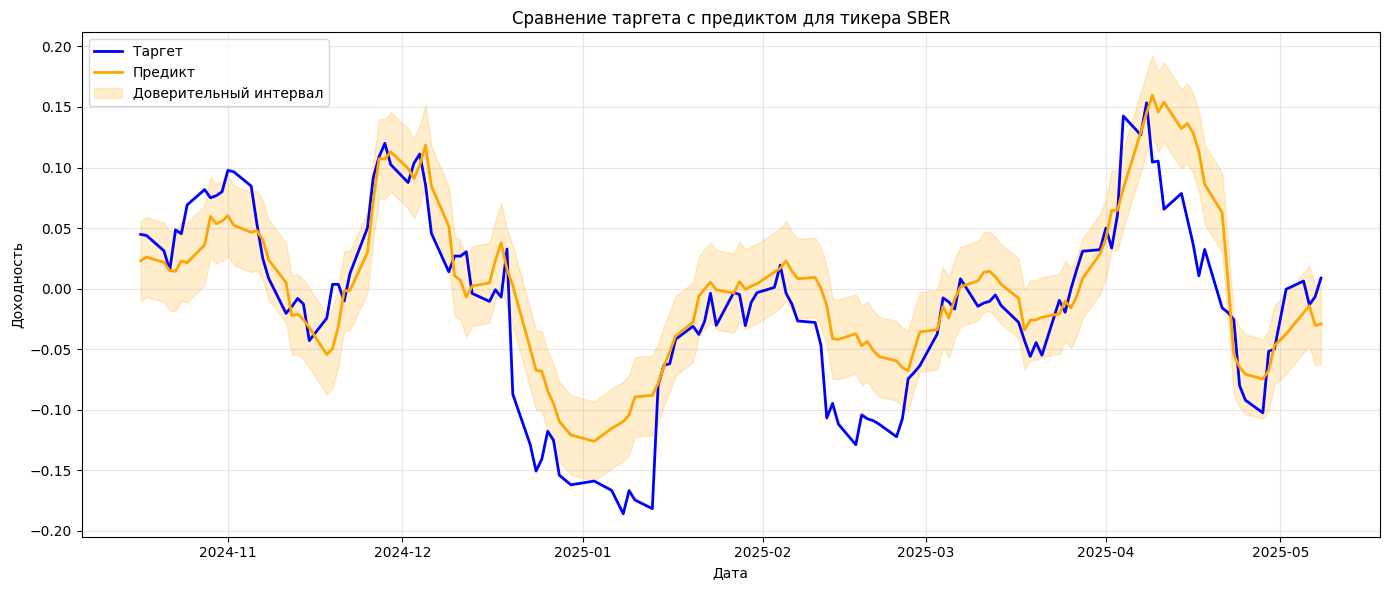

In [42]:
ticker = "SBER"

plot_dnn_predictions(
    df=data,
    dataloader=test_loader,
    ticker=ticker,
    preds=lstm_preds,
    targets=lstm_targets,
    lower_bounds=lstm_lb,
    upper_bounds=lstm_ub
)

## CNN+GRU модель прогнозирования доходностей

Поэксперементируем и попробуем сделать прогноз, используя GRU.

In [43]:
gru_model = GRUForecaster(
    feature_dim=feature_dim,
    num_tickers=num_tickers,
    gru_hidden=128,
    gru_layers=2,
    dropout=0.3,
    cnn_embed_dim=32
).to(DEVICE)

gru_criterion = torch.nn.L1Loss()
gru_optimizer = Adam(
    params=gru_model.parameters(),
    lr=0.0005,
    weight_decay=0.001
)
gru_scheduler = ReduceLROnPlateau(
    optimizer=gru_optimizer,
    patience=10,
    factor=0.5
)

gru_trainer = Trainer(
    model=gru_model,
    criterion=gru_criterion,
    optimizer=gru_optimizer,
    scheduler=gru_scheduler,
    device=DEVICE)

train_losses, val_losses = gru_trainer.train(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    patience=20,
    model_name="gru"
)

Эпоха [10/100] | Train loss: 0.368197 | Val loss: 0.332175
Эпоха [20/100] | Train loss: 0.312342 | Val loss: 0.289409
Эпоха [30/100] | Train loss: 0.289489 | Val loss: 0.282506
Эпоха [40/100] | Train loss: 0.279664 | Val loss: 0.273560
Эпоха [50/100] | Train loss: 0.268550 | Val loss: 0.280951
Эпоха [60/100] | Train loss: 0.265470 | Val loss: 0.271993
Эпоха [70/100] | Train loss: 0.258835 | Val loss: 0.266344
Эпоха [80/100] | Train loss: 0.253347 | Val loss: 0.267656
Эпоха [90/100] | Train loss: 0.256728 | Val loss: 0.262382


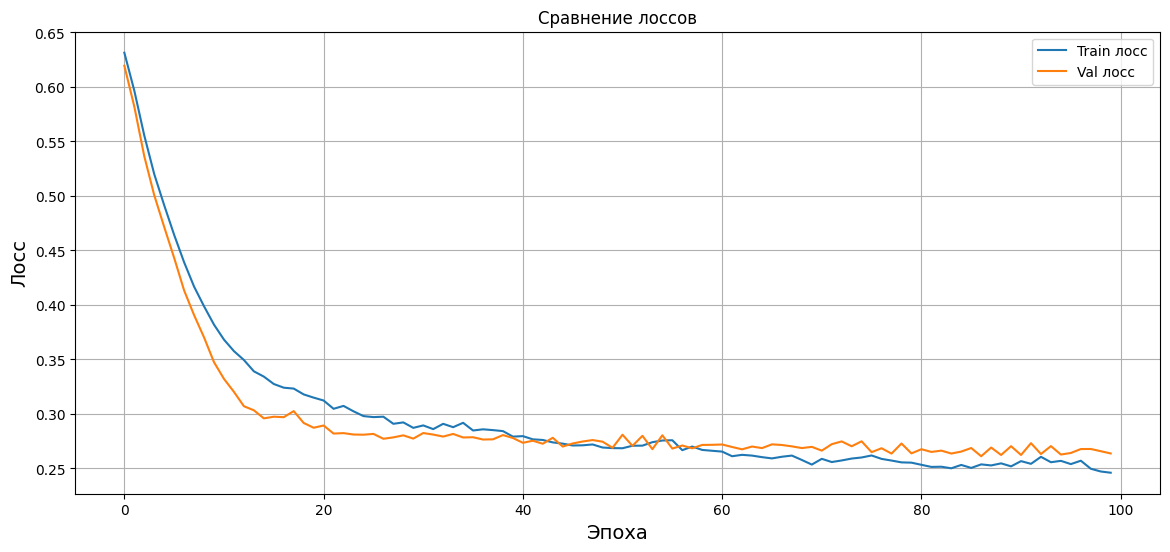

In [44]:
plot_losses(train_losses, val_losses)

In [45]:
gru_loss = gru_trainer.evaluate(dataloader=test_loader)

gru_preds, gru_targets, gru_lb, gru_ub = gru_trainer.predict(
    dataloader=test_loader,
    target_scaler=target_scaler,
    train_loader=train_loader,
    ci_coef=1
)

Test loss: 0.409567


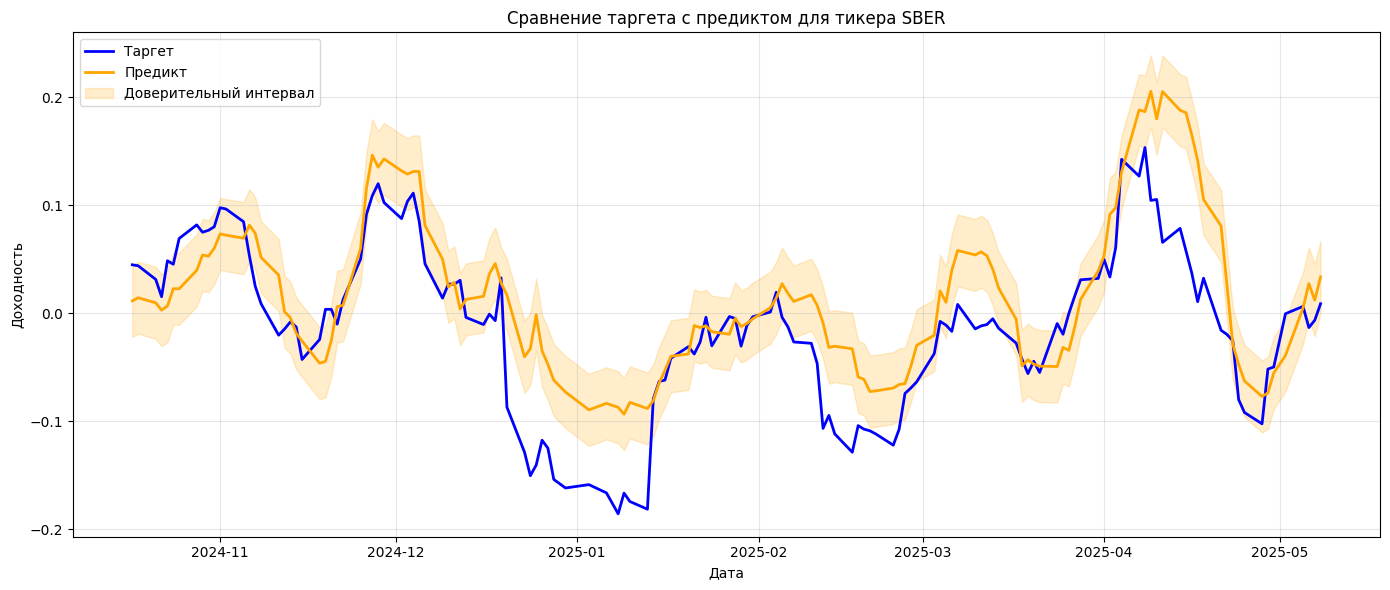

In [46]:
ticker = "SBER"

plot_dnn_predictions(
    df=data,
    dataloader=test_loader,
    ticker=ticker,
    preds=gru_preds,
    targets=gru_targets,
    lower_bounds=gru_lb,
    upper_bounds=gru_ub
)

## CNN+LSTM+Attention модель прогнозирования доходностей

Теперь попробуем добавить механизм внимания к LSTM и посмотрим, что из этого выйдет.

In [47]:
att_lstm_model = AttentionLSTMForecaster(
    feature_dim=feature_dim,
    num_tickers=num_tickers,
    lstm_hidden=256,
    attention_heads=16,
    lstm_layers=3,
    dropout=0.5,
    cnn_embed_dim=32
).to(DEVICE)

att_lstm_cr = torch.nn.L1Loss()
att_lstm_opt = Adam(
    params=att_lstm_model.parameters(),
    lr=0.0005,
    weight_decay=0.001
)
att_lstm_sch = ReduceLROnPlateau(
    optimizer=att_lstm_opt,
    patience=10,
    factor=0.5
)

att_lstm_trainer = Trainer(
    model=att_lstm_model,
    criterion=att_lstm_cr,
    optimizer=att_lstm_opt,
    scheduler=att_lstm_sch,
    device=DEVICE)

train_losses, val_losses = att_lstm_trainer.train(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    patience=20,
    model_name="att_lstm"
)

Эпоха [10/100] | Train loss: 0.401604 | Val loss: 0.355050
Эпоха [20/100] | Train loss: 0.370760 | Val loss: 0.334379
Эпоха [30/100] | Train loss: 0.339349 | Val loss: 0.323618
Эпоха [40/100] | Train loss: 0.334142 | Val loss: 0.319649
Эпоха [50/100] | Train loss: 0.313709 | Val loss: 0.306212
Ранняя остановка на эпохе 56


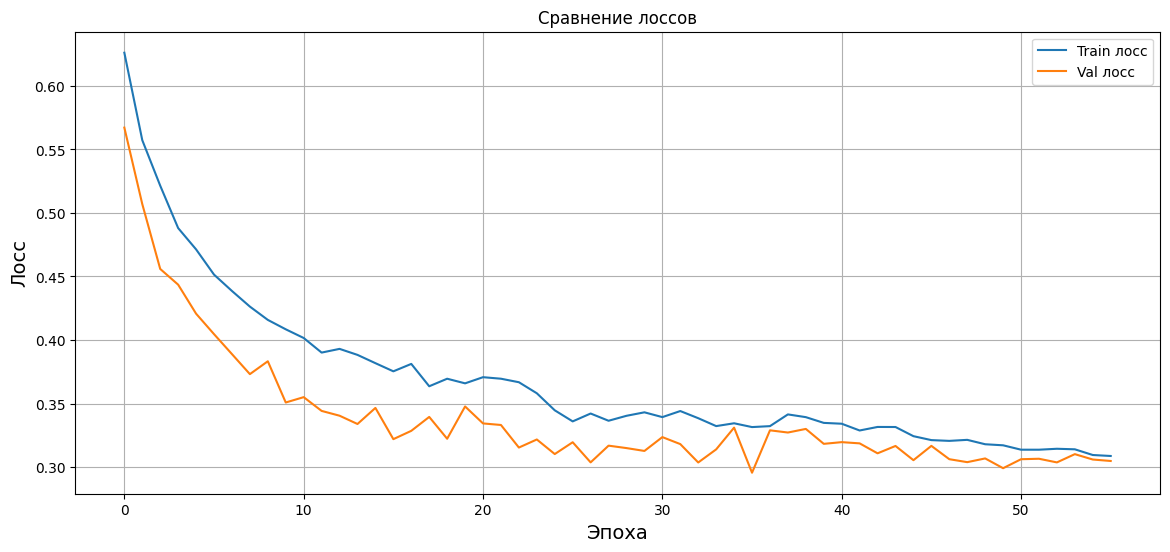

In [48]:
plot_losses(train_losses, val_losses)

In [49]:
att_lstm_loss = att_lstm_trainer.evaluate(dataloader=test_loader)

att_lstm_preds, att_lstm_targets, att_lstm_lb, att_lstm_ub = att_lstm_trainer.predict(
    dataloader=test_loader,
    target_scaler=target_scaler,
    train_loader=train_loader,
    ci_coef=1
)

Test loss: 0.401983


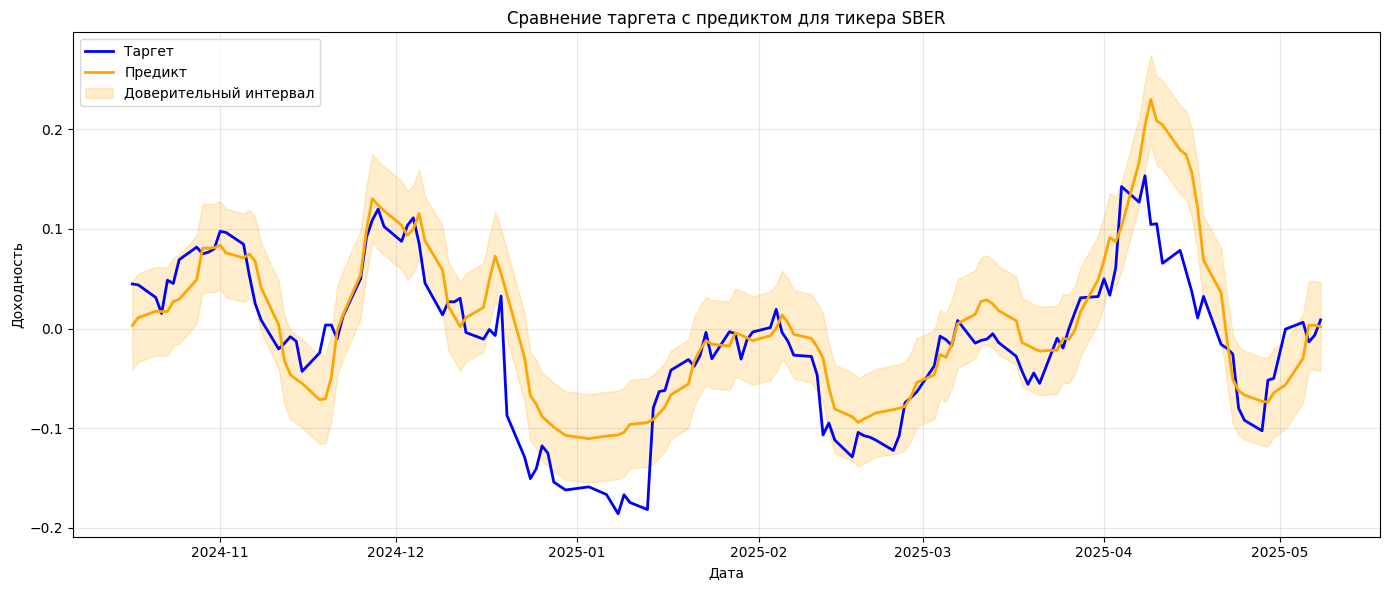

In [50]:
ticker = "SBER"

plot_dnn_predictions(
    df=data,
    dataloader=test_loader,
    ticker=ticker,
    preds=att_lstm_preds,
    targets=att_lstm_targets,
    lower_bounds=att_lstm_lb,
    upper_bounds=att_lstm_ub
)

## CNN+GRU+Attention модель прогнозирования доходностей

А теперь добавим механизм внимания к GRU.

In [51]:
att_gru_model = AttentionGRUForecaster(
    feature_dim=feature_dim,
    num_tickers=num_tickers,
    gru_hidden=256,
    attention_heads=16,
    gru_layers=3,
    dropout=0.5,
    cnn_embed_dim=32
).to(DEVICE)

att_gru_cr = torch.nn.L1Loss()
att_gru_opt = Adam(
    params=att_gru_model.parameters(),
    lr=0.0005,
    weight_decay=0.001
)
att_gru_sch = ReduceLROnPlateau(
    optimizer=att_gru_opt,
    patience=10,
    factor=0.5
)

att_gru_trainer = Trainer(
    model=att_gru_model,
    criterion=att_gru_cr,
    optimizer=att_gru_opt,
    scheduler=att_gru_sch,
    device=DEVICE)

train_losses, val_losses = att_gru_trainer.train(
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=100,
    patience=20,
    model_name="att_gru"
)

Эпоха [10/100] | Train loss: 0.382370 | Val loss: 0.327113
Эпоха [20/100] | Train loss: 0.352211 | Val loss: 0.328382
Эпоха [30/100] | Train loss: 0.337892 | Val loss: 0.304146
Эпоха [40/100] | Train loss: 0.326361 | Val loss: 0.296441
Эпоха [50/100] | Train loss: 0.314797 | Val loss: 0.298045
Эпоха [60/100] | Train loss: 0.318899 | Val loss: 0.297012
Эпоха [70/100] | Train loss: 0.314836 | Val loss: 0.294563
Эпоха [80/100] | Train loss: 0.306994 | Val loss: 0.290889
Эпоха [90/100] | Train loss: 0.308066 | Val loss: 0.293068


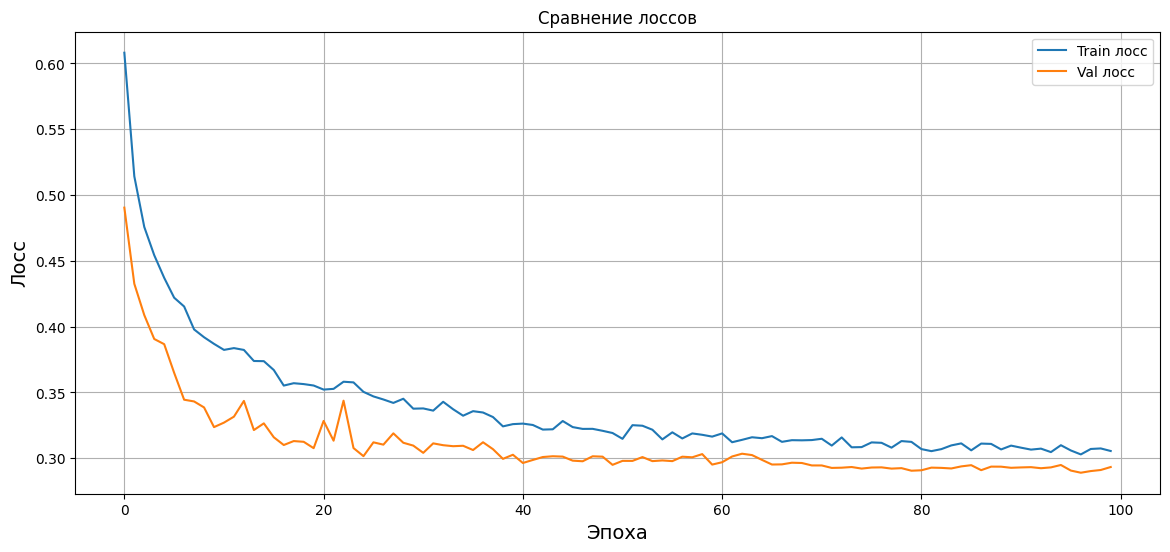

In [52]:
plot_losses(train_losses, val_losses)

In [53]:
att_gru_loss = att_gru_trainer.evaluate(dataloader=test_loader)

att_gru_preds, att_gru_targets, att_gru_lb, att_gru_ub = att_gru_trainer.predict(
    dataloader=test_loader,
    target_scaler=target_scaler,
    train_loader=train_loader,
    ci_coef=1
)

Test loss: 0.385417


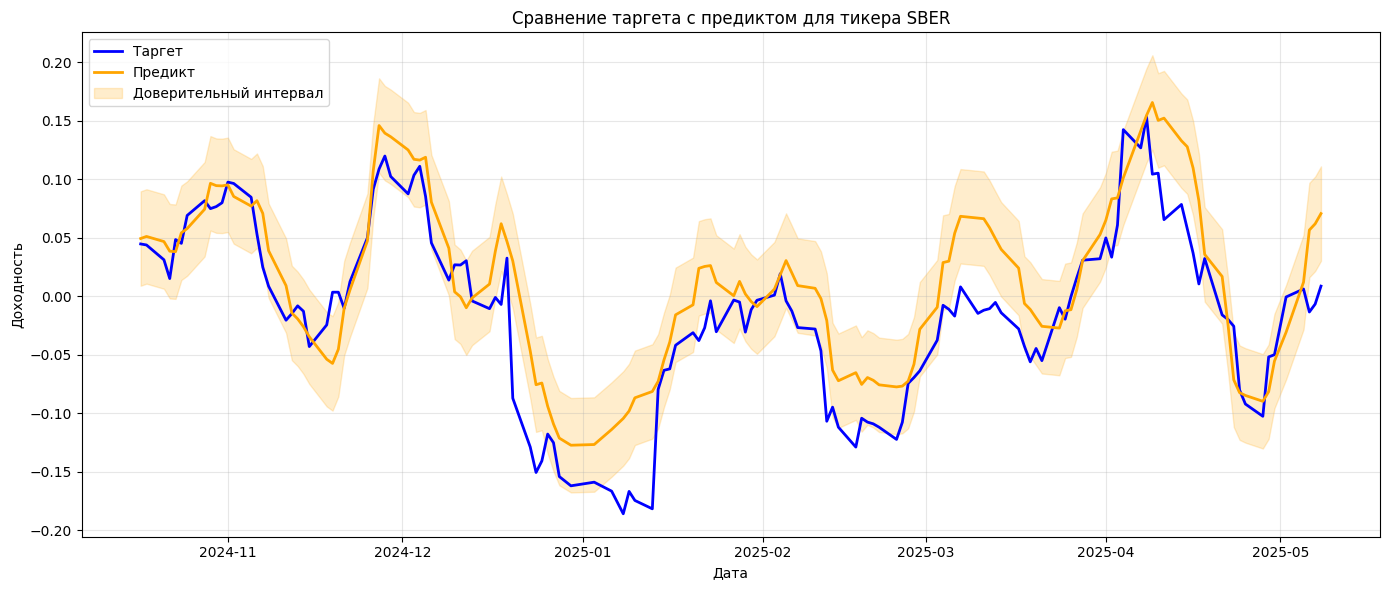

In [54]:
ticker = "SBER"

plot_dnn_predictions(
    df=data,
    dataloader=test_loader,
    ticker=ticker,
    preds=att_gru_preds,
    targets=att_gru_targets,
    lower_bounds=att_gru_lb,
    upper_bounds=att_gru_ub
)

## Оптимизация весов портфеля на основе модели Блэка-Литтермана

В прошлых разделах с помощью DL моделей были получены __предсказания доходности__ по каждому тикеру. В данном разделе попробуем улучшить метрики нашего портфеля с помощью `модели Блэка-Литтермана`.  
  
Основная идея модели состоит в следующем:
- Сначала рассчитываются априорные рыночные доходности на основе рыночной капитализации активов, ковариационной матрицы и коэффициента неприятия риска.
- Затем эти априорные оценки корректируются на основе __субъективных прогнозов (в нашем случае - это прогноз DL модели)__. Субъективные прогнозы могут быть заданы как абсолютные или относительные ожидания доходностей отдельных активов с указанием степени уверенности в этих прогнозах.
- После интеграции субъективных прогнозов и уровней уверенности модель формирует апостериорные доходности активов, на основе которых уже рассчитываются оптимальные веса инвестиционного портфеля.

In [55]:
weights_optimizer = BlackLittermanOptimizer(
    historical_prices=data,
    market_prices=imoex,
    test_start_date=BACKTEST_DATE
)
weights_optimizer.calculate_market_prior()

(ticker
 CHMF    0.068547
 GAZP    0.107372
 LKOH    0.106600
 MGNT    0.077571
 NVTK    0.103813
 ROSN    0.118639
 SBER    0.126611
 YDEX    0.096066
 dtype: float64,
 ticker      CHMF      GAZP      LKOH      MGNT      NVTK      ROSN      SBER  \
 ticker                                                                         
 CHMF    0.093486  0.035164  0.034040  0.033972  0.036550  0.038648  0.038949   
 GAZP    0.035164  0.110145  0.051650  0.040678  0.046366  0.058596  0.059290   
 LKOH    0.034040  0.051650  0.093531  0.039812  0.051219  0.063368  0.053496   
 MGNT    0.033972  0.040678  0.039812  0.108228  0.038843  0.045983  0.046629   
 NVTK    0.036550  0.046366  0.051219  0.038843  0.104788  0.056897  0.054161   
 ROSN    0.038648  0.058596  0.063368  0.045983  0.056897  0.103868  0.063196   
 SBER    0.038949  0.059290  0.053496  0.046629  0.054161  0.063196  0.115300   
 YDEX    0.036524  0.044290  0.042069  0.043554  0.045077  0.046591  0.058848   
 
 ticker      YDEX  

__Модель CNN+GRU+Attention__ показала наилучшую метрику __MAE__ среди моделей, поэтому будем использовать именно эту модель.

In [56]:
att_gru_bl = weights_optimizer.prepare_predictions(
    df=data,
    predictions=att_gru_preds,
    targets=None,
    test_start_date=BACKTEST_DATE
)

С помощью метода `prepare_views_and_confidences` можно рассчитать уверенности на основе доверительного интервала. Но в качестве эксперимента зададим уверенности вручную.

In [57]:
views, _ = weights_optimizer.prepare_views_and_confidences(
    preds_df=att_gru_bl,
    lower=att_gru_lb,
    upper=att_gru_ub,
    confidence_lower=0.1,
    confidence_upper=0.8,
    scaling_factor=0.6
)

In [58]:
confidences = [
    0.1,
    0.5,
    0.5,
    0.3,
    0.3,
    0.1,
    0.1,
    0.7
]

In [59]:
optimal_weights, S, market_prior, posterior_returns = weights_optimizer.optimize_weights(
    views=views,
    confidences=confidences
)

c:\Users\User\Desktop\hsemaster\global_env\Lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


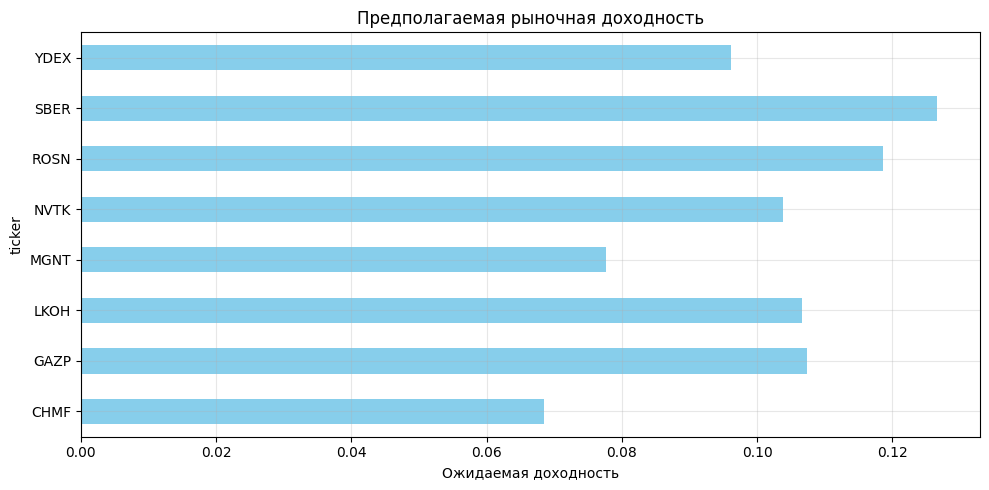

In [60]:
weights_optimizer.plot_market_prior(
    market_prior=market_prior,
    mode="plt"
)

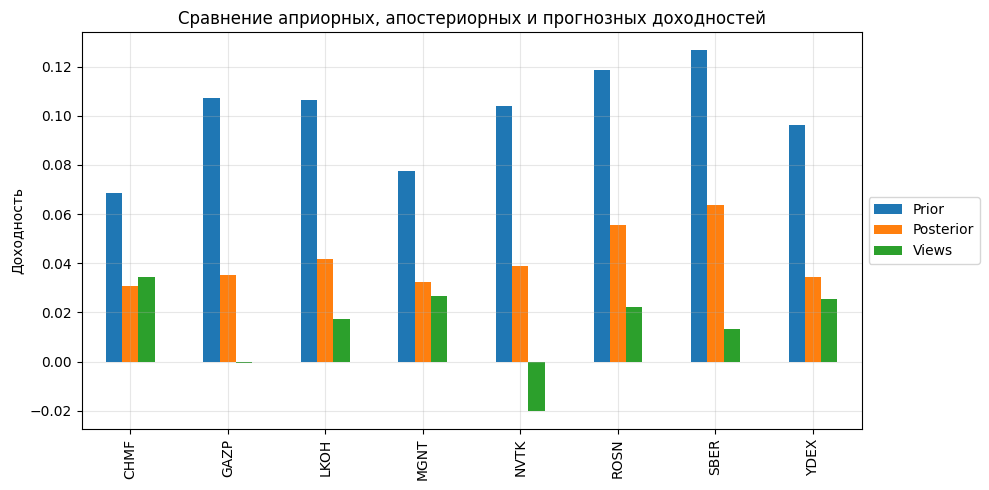

In [61]:
weights_optimizer.plot_prior_posterior_views(
    market_prior=market_prior,
    posterior_returns=posterior_returns,
    views=views,
    mode="plt"
)

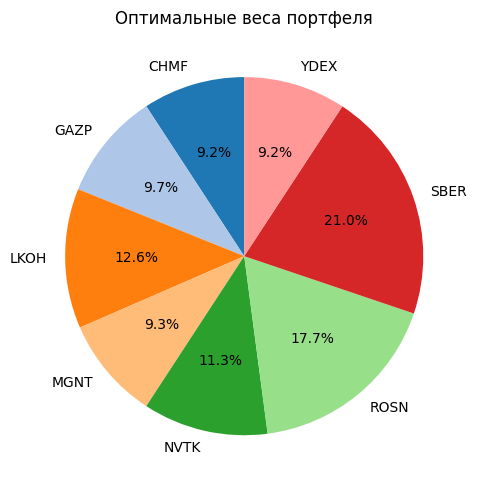

In [62]:
weights_optimizer.plot_optimal_weights(
    weights=optimal_weights,
    mode="plt"
)

Делаем бэктест с квартальной ребалансировкой и полученными оптимальными весами.

In [63]:
bl_bt = Backtester(df=data, init_cash=100_000, fees=0.01, test_start_date=BACKTEST_DATE)
rb_pf = bl_bt.run_buy_and_hold_rebalanced(rebalance_freq="Q", weights=optimal_weights)

In [64]:
bl_bt.portfolio_performance(portfolio=rb_pf)

Sharpe ratio: 0.26
Sortino ratio: 0.40
Max drawdown: -19.02%
Total return: 1.88%


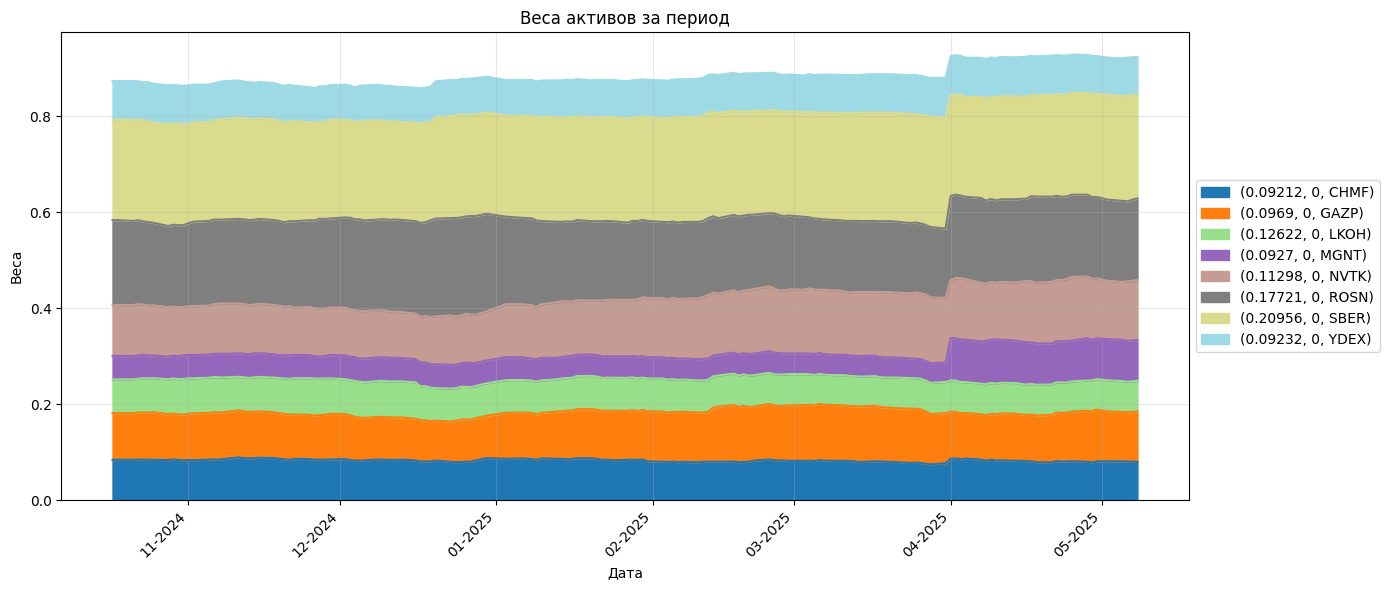

In [65]:
bl_bt.plot_weights(rb_pf)

> __Вывод:__  
> Подбор оптимальных весов и добавление ребалансировки портфеля значительно улучшило метрики в сравнении с бейзлайн стратегией и сигнальной стратегией. Доходность увеличилась с 0.22% до 1.88%, коэффициенты Шарпа и Сортино также увеличились с 0.16 до 0.26 и с 0.25 до 0.40 соответственно. Однако, портфель все равно проигрывает Индексу полной доходности и Индексу гос. облигаций.